In [1]:
import numpy as np
from qiskit import *
import random
import time
from numpy import log as ln
import warnings
import math
warnings.filterwarnings('ignore', module = 'qiskit')
# warnings.filterwarnings(action='once')

from qiskit.algorithms.optimizers import ADAM, AQGD, COBYLA, SPSA, TNC, CG, L_BFGS_B, GSLS, NELDER_MEAD, NFT, P_BFGS, POWELL, SLSQP
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI
from qiskit.opflow import CircuitStateFn, StateFn, I, X, Y, Z, H, CX, Zero, One, OperatorBase

from itertools import combinations as cm

In [2]:
primes = [2,3]

In [3]:
def generate_ZZcircuit(params, primes, n,assigned=True):
    cir = QuantumCircuit(len(primes))
    layers = int(len(params)/((2 * len(primes)) + len(combinations)))
    thetas = [qiskit.circuit.Parameter(str(i)) for i in range(layers * ((2 * len(primes)) + len(combinations)))]
    thetas_reshape = np.reshape(np.asarray(thetas),(layers, ((2 * len(primes)) + len(combinations))))
    params = np.reshape(np.asarray(params),(layers, ((2 * len(primes)) + len(combinations))))
    combs = list(cm(range(len(primes)), 2))
    cir.h(range(len(primes)))
    
    for m in range(layers):
        l = len(params[m])
        g = thetas_reshape[m][0: len(primes)]
        g_prime = [2*ln(n/math.sqrt(6))*ln(2), 2*ln(n/math.sqrt(6))*ln(3)]
        a = thetas_reshape[m][len(primes): (len(primes) + len(combs))]
        a_prime = [ln(2)*ln(3)]
        b = thetas_reshape[m][(len(primes) + len(combs)) : l]
        
        for h in range(len(primes)):
            cir.rz(g_prime[h]*g[h], h)
        
        i = 0
        for j, k in combs:
            cir.rzz(a_prime[i]*a[i], j, k)
            i += 1
        for l in range(len(primes)):
            cir.rx(b[l], l)
            
    if assigned == True:
        thetas_reshape = thetas_reshape.flatten()
        params = params.flatten()
        p_dict = {thetas_reshape[i] : params[i] for i in range(len(thetas))}
        cir.assign_parameters(p_dict, inplace=True)
    cir.measure_all()
    
    return cir, thetas

[0.931021476252023, 2.737767587343901, 0.9130292714509836, 2.143298409845112, 2.6817500098380984]


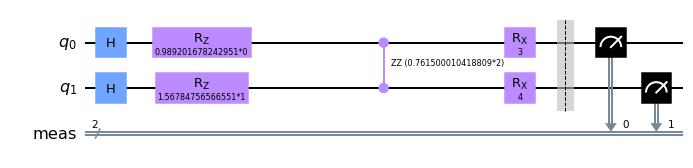

In [4]:
combinations = list(cm(range(len(primes)), 2))
hyperparam = [random.uniform(0,np.pi) for _ in range(1 * ((2 * len(primes)) + len(combinations)))]
print(hyperparam)
cir, free_params = generate_ZZcircuit(hyperparam, primes, 5,assigned=False)
cir.draw('mpl')

In [5]:
def obj_function(counts, n, penalty):
    max_c = 0
    max_bit = ""
    for c in counts:
        if counts[c] >= max_c:
            max_c =  counts[c]
            max_bit = c
    comp_primes = 1
    for i in range(len(max_bit)):
        comp_primes *= primes[i]**int(max_bit[i])
    p = 0
    if penalty == 1:
        if abs(comp_primes-n) > n:
            p += comp_primes
    return abs((n - comp_primes) + p)

In [6]:
def gen_f(n):
    
    def f(theta):
        qc, free_params = generate_ZZcircuit(theta, primes, n)
        back = Aer.get_backend('aer_simulator')
#         back.set_options(device='GPU')
        job_sim = execute(qc, backend = back, shots = 2048).result()
        counts = job_sim.get_counts(qc)
        
        return obj_function(counts, n, 1)

    return f

In [7]:
def X_generator(primes, identity):
    #Generate X value for hamiltonian
    constant = 0

    for i in range(len(primes)):
        #Build Constant value iteratively
        constant += ln(primes[i])
        
        if i == 0:
            z_value = Z
        else:
            z_value = I
        #Build rest of X
        for j in range(1, len(primes)):
            if j == i:
                z_value = z_value ^ Z
            else:
                z_value = z_value ^ I
        if i == 0:
            x = -ln(primes[i]) * z_value
        else:
            x -= ln(primes[i]) * z_value
    #Combine Both to form X
    x += constant * identity
    
    return x

def hamiltonian(n, primes):
    #Generate Hamitonian according to number of primes
    identity = I
    
    for i in range(len(primes) - 1):
        identity = identity ^ I
        
    x = X_generator(primes, identity)
    
    lnn = float(ln(n))
    
    h = ((lnn**2) * identity) - (lnn * x) + (1 / 4 * (x ** 2))
    
    return h

In [8]:
def _convert_to_gradient_function(gradient_object, layers, n):

        def gradient_function(current_point):

            cir, free_params = generate_ZZcircuit(current_point, primes, n, assigned=False)
            cir.remove_final_measurements()
            c = hamiltonian(n, primes)
            op = ~StateFn(c) @ CircuitStateFn(primitive=cir, coeff=1.)
            grad_object = gradient_object.convert(operator=op, params=free_params)
            value_dict = {free_params[i]: current_point[i] for i in range(len(free_params))}
            x = grad_object.assign_parameters(value_dict).eval()
            print(np.real(x))
#             analytical_gradients = np.array(x)# Change this part
            return np.real(x)
        
        return gradient_function

In [9]:
def run(optimizer, layers, func, gradient_function, n):
    g_f = _convert_to_gradient_function(gradient_function, layers, n)
    theta = [np.pi for _ in range(layers * ((2 * len(primes)) + len(combinations)))]
    theta, loss, _ = optimizer.optimize(
                num_vars=len(theta),
                objective_function=func,
                initial_point=theta,
                gradient_function=g_f
                )
    return loss,theta

In [10]:
# grad = Gradient(grad_method="param_shift")
# optimizer = CG(maxiter=100)

In [11]:
# n = 2
# loss, thetas = run(optimizer, 1, gen_f(n), grad, n)
# print(loss, thetas)

In [12]:
# cir, params = generate_ZZcircuit(thetas, primes, n)

# from qiskit.visualization import plot_histogram
# back = Aer.get_backend('aer_simulator')
# back.set_options(device='GPU')
# job_sim = execute(cir, backend = back, shots = 2048).result()
# counts = job_sim.get_counts(cir)

# plot_histogram(counts)

In [13]:
# [random.uniform(0, 2 * np.pi) for _ in range(layers * ((2 * len(primes)) + len(combinations)))]

In [14]:
dist =  []
lr_list = [5]
for j in range(3, 4):
    temp = []
    for l in lr_list:
        temp1 = []
        for i in range(1):
            grad = Gradient(grad_method="param_shift")
            optimizer = ADAM(maxiter=l, lr=1.0)
            n = j
            loss, thetas = run(optimizer, 1, gen_f(n), grad, n)
            temp1.append(loss)
        temp.append(temp1)
    dist.append(temp)
    print(j)

[ 0.00000000e+00  5.55111512e-17 -5.55111512e-17  2.90638640e-01
  1.45608242e-01]
[ 0.04851697  0.06099725 -0.05779485 -0.04696098 -0.18067776]
[ 0.01467327  0.0164373   0.11903846 -0.02448548 -0.09805553]
[-0.00290969 -0.00224165  0.12333304 -0.10485645 -0.11636468]
[-0.0136104   0.00069576  0.12853204 -0.12592895 -0.10496524]
3


IndexError: list index out of range

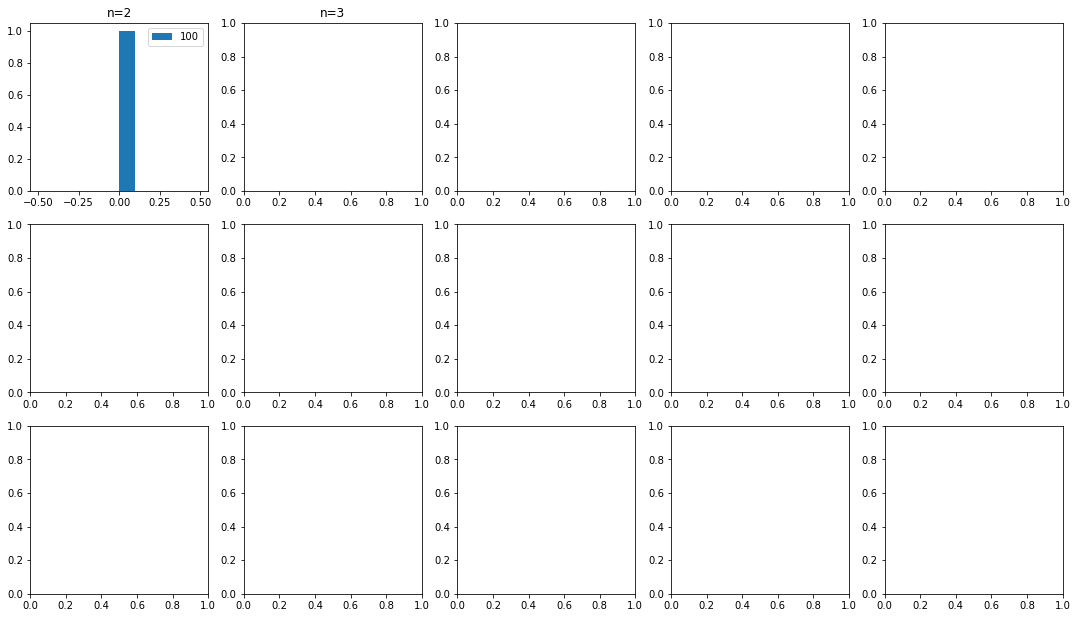

In [16]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(3, 5)
fig.set_size_inches(18.5, 10.5)
n = 0
for k in range(3):
    for l in range(5):
        ax[k][l].set_title("n="+ str(n+2) )
        ax[k][l].hist(dist[n], bins=10, label=["100", "200", "400", "500"])
        ax[k][l].legend()
        n += 1
        if n >= 14:
            break

In [17]:
dist

[[[0]]]